### Wakefield simulation of accelerator cavity with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity up to a partially decayed wake
* Calculation of the longitudinal wake potential and impedance of partially decayed and:
    * Partially decayed to fully decayed impedance with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Differential Evolution algorithm
    * Extrapolation of partially decayed wake to fully decayed with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Resonator formalism
* Plotting of the results

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl

### Domain setup and grid generation

Wakis will import the geometry files stored in `.stl` format and generate a grid with the number of mesh cells selected by the user `Nx`, `Ny`, `Nz`

In [2]:
# ---------- Domain setup ---------
# Read geometry -change path if errors are found!
stl_cavity = 'notebooks/data/002_vacuum_cavity.stl' 
stl_shell = 'notebooks/data/002_lossymetal_shell.stl'

# Set up geometry & materials dictionaries
stl_solids = {'cavity': stl_cavity, 'shell': stl_shell}
stl_materials = {'cavity': 'vacuum', 'shell': [30, 1.0, 30]}

# Domain bounds
surf = pv.read(stl_shell) + pv.read(stl_cavity)
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)

# Number of mesh cells
Nx = 80
Ny = 80
Nz = 141
#dt = 2.187760221e-12 # like CST

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0)

Generating grid...
Importing stl solids...


Below, a few examples of quick geometry, mesh and domain visualization in 3D to inspect the generated grid and imported solids:

In [3]:
# Plot the imported geometry 3d interactive plot
grid.plot_solids()

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


Widget(value='<iframe src="http://localhost:32833/index.html?ui=P_0x7f9f9eb44e10_0&reconnect=auto" class="pyvi…

In [4]:
# Plot the geometry and the grid on 3d interactive plot
grid.inspect()

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


Widget(value='<iframe src="http://localhost:32833/index.html?ui=P_0x7f9f9a5fce50_1&reconnect=auto" class="pyvi…

### Boundary conditions and EM solver

In [5]:
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, bg='pec')

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Pre-computing ...
Total initialization time: 2.8886845111846924 s


A few examples on how to inspect the generated fields `E`, `H`, `J`, and material tensors `sigma` (conductivity $\sigma$), `ieps` ($\varepsilon^{-1}$), `imu` ($\mu^{-1}$) 

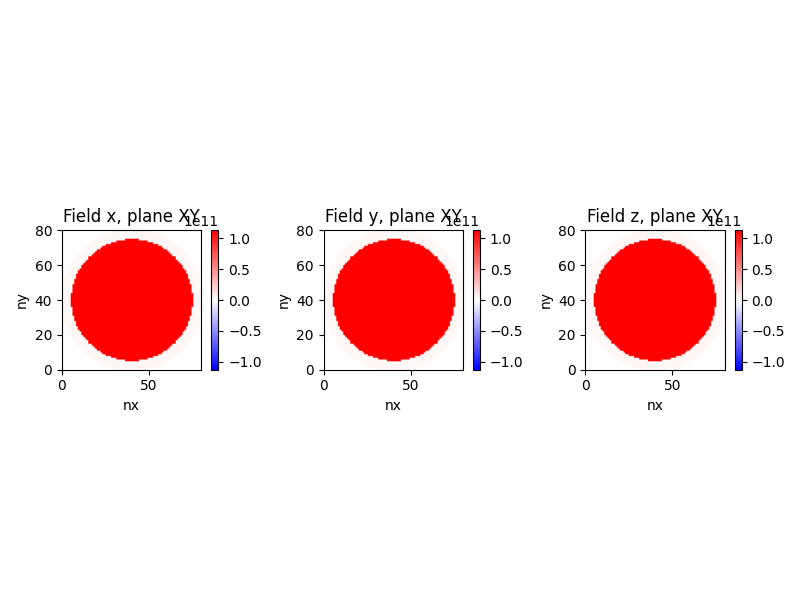

In [6]:
# Inspect the material tensors before running the simulations
solver.ieps.inspect(plane='XY',) 

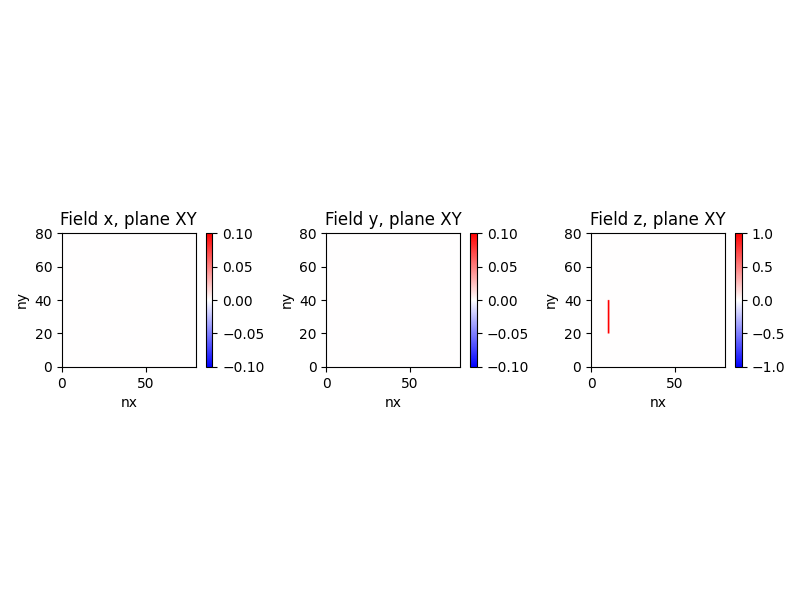

In [ ]:
# Assign initial conditions and visualize [Optional - not needed for wakefield!]
solver.E[10,20:40,:,'z'] = 1.
solver.E.inspect(plane='XY') 
solver.E[10,20:40,:,'z'] = 0. # and restore it back!

### Wakefield settings & Run

The wakefield simulation will run up to 10 m which will give a partially decayed wake and a non-converged impedance - this will be the starting point of IDDEFIX extrapolation !

In [9]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
add_space = 10   # no. cells

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                add_space=add_space,
                results_folder='results/',
                Ez_file='results/001_Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength 

In [10]:
solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 add_space=add_space,
                 plot=False)

Running electromagnetic time-domain simulation...


100%|██████████| 8099/8099 [15:13<00:00,  8.86it/s]


Reading h5 file results/001_Ez.h5
Calculating longitudinal wake potential WP(s)


100%|██████████| 67932/67932 [00:21<00:00, 3231.91it/s]


Calculating transverse wake potential WPx, WPy...


100%|██████████| 67932/67932 [00:00<00:00, 129870.51it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


It's done! Now we can plot the results:

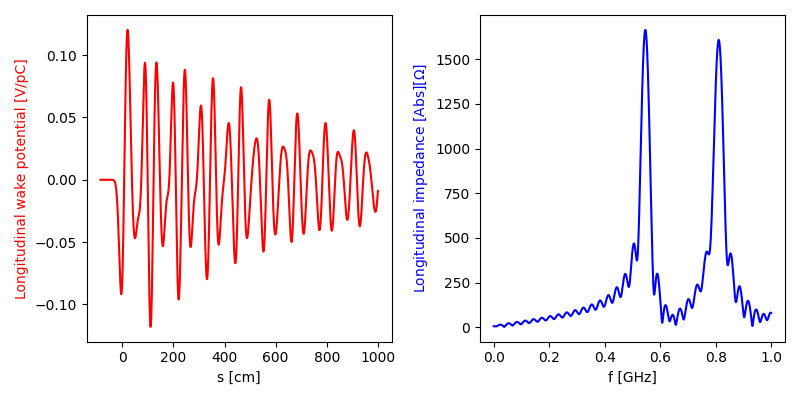

In [18]:
fig, ax = plt.subplots(1,2, figsize=[8,4], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

## Partial to Fully decayed impedance with IDDEFIX

The [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) (Impedance Determination through Differential Evolution FItting and eXtrapolation) python package will take the partially decayed wake and give back the fully decayed wake using the **Resonator formalism** and **Diferential Evolution's** algorithms powered with `scipy`